In [1]:
#pip install nbinteract

### A case study: using CLUE datasets of Melbourne Open Data

# **Where should public transportation be enhanced in the city of Melbourne?**

The City of Melbourne has always evolved, and so have the numbers of its residential dwellings and employment population (based on data available on Melbourne Open Data). Without a consistent or parallel increase of off-street parking, the city will face the difficulty in providing enough spaces for parking of private transportation. To resolve this problem, the city planner needs to locate the potential areas where extension of public transportation should be implemented to replace the need for off-street parking.


## Purpose: 
This case study is intended to provide educational instructions of how CLUE datasets can be used for city planners or individuals whose have some knowledge in data analysis.

## Pre-requisite skills:
- Python scripting (Basic)
- Data analysis (Basic EDA and visualizations)

## Solution:
By looking at the population trend of residential dwellings and employments at different Melbourne city blocks, the city planner can project amount of public transportation services necessary to sufficiently accommodate potential travellers to or/and from those city blocks.



# **Working with Residential dwelling datasets**

In [28]:
#CLUE datasets
#======================================================
import pandas as pd
#Residential dwellings data
resident = pd.read_csv('/content/drive/MyDrive/Notebooks/SIT782/CLUE/Residential_dwellings.csv')
#Total records before cleaning
print('Total records before cleaning is',len(resident))
#Data cleaning (remove duplicated values)
resident.drop_duplicates(inplace = True)
#Total records after cleaning
print('Total records after cleaning is',len(resident))
#Select only necessary columns
selected_columns =['Census year','Block ID','CLUE small area','Dwelling number']
resident = resident[selected_columns]
#Sum the Dwelling number based on Block ID and Year
resident_by_block = resident.groupby(['Census year','Block ID']).agg({'CLUE small area':'max','Dwelling number':'sum'})
print('Total records after grouping (by Block ID) is',len(resident_by_block))
#Detail of the residential dwellings by block
resident_by_block.head()


Total records before cleaning is 177733
Total records after cleaning is 177729
Total records after grouping (by Block ID) is 8036


CLUE small area  Dwelling number
Census year Block ID                                  
2002        11        Melbourne (CBD)               97
            12        Melbourne (CBD)              189
            13        Melbourne (CBD)              113
            14        Melbourne (CBD)               87
            15        Melbourne (CBD)              282

# **Working with Emploment datasets**

In [33]:
#Employment data
employment = pd.read_csv('/content/drive/MyDrive/Notebooks/SIT782/CLUE/Employment_by_block_by_CLUE_industry.csv')
#Total records before cleaning
print('Total records before cleaning is',len(employment))
#Cleaning the data (remove missing values at [Total employment in block])
employment.dropna(subset=['Total employment in block'],inplace=True)
#Total records after cleaning
print('Total records afer cleaning is',len(employment))
#Select only necessary columns
selected_columns =['Census year','Block ID','Total employment in block']
employment = employment[selected_columns]
#Sum the employment based on Block ID and Year
employment_by_block = employment.groupby(['Census year','Block ID']).sum()
print('Total records after grouping (by Block ID) is',len(employment_by_block))
#Detail of the employment_by_block
employment_by_block.head()

Total records before cleaning is 11182
Total records afer cleaning is 8759
Total records after grouping (by Block ID) is 8759


Total employment in block
Census year Block ID                           
2002        0                          319729.0
            1                               6.0
            2                             169.0
            4                            1174.0
            5                              12.0

# **Working with Off-street Parking datasets**

In [31]:
#Off-street parking data
parking = pd.read_csv('/content/drive/MyDrive/Notebooks/SIT782/CLUE/Off-street_car_parks_with_capacity_and_type.csv')
#Total records before cleaning
print('Total records before cleaning is',len(parking))
#Data cleaning (remove duplicate values)
parking.drop_duplicates(inplace=True)
#Total records after cleaning
print('Total records after cleaning is',len(parking))
#Select only necessary columns
selected_columns =['Census year','Block ID','Parking spaces']
parking = parking[selected_columns]
#Sum the parking based on Block ID and Year
parking_by_block = parking.groupby(['Census year','Block ID']).sum()
print('Total records after grouping (by Block ID) is',len(parking_by_block))
#Detail of the employment_by_block
parking_by_block.head()


Total records before cleaning is 124114
Total records after cleaning is 122461
Total records after grouping (by Block ID) is 9939


Parking spaces
Census year Block ID                
2002        1                    270
            6                    500
            11                   303
            12                   749
            13                   622

# **Merge and explore the 3 datasets (Resident, Employment, & Parking)**

Formulate the model to identify a suitable number of parking slots based on residential dwelling or employment.

                      CLUE small area  ...  Parking spaces
Census year Block ID                   ...                
2002        11        Melbourne (CBD)  ...             303
            12        Melbourne (CBD)  ...             749
            13        Melbourne (CBD)  ...             622
            14        Melbourne (CBD)  ...            1229
            15        Melbourne (CBD)  ...              88

[5 rows x 4 columns]


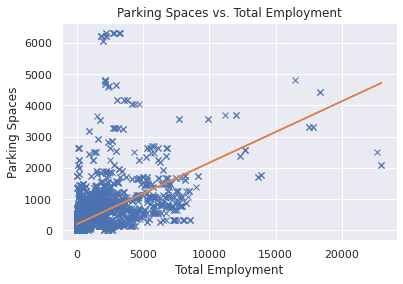

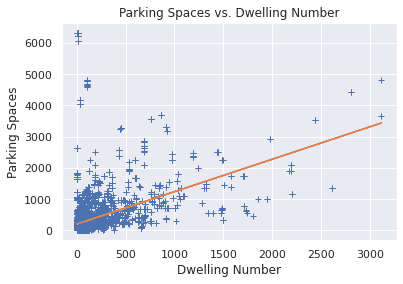

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(color_codes=True)

#Combine the datasets (only take the blocks that match between three datasets)
data = resident_by_block.merge(employment_by_block, left_index= True, right_index=True)
data = data.merge(parking_by_block,left_index=True,right_index=True)
print(data.head())
#Prepare data for scatter plots
x1 = data['Total employment in block']
x2 = data['Dwelling number']
y = data['Parking spaces']
#Plot the data points (Parking Spaces vs. Total Employment) and regression line
plt.plot(x1,y,'x')
a, b = np.polyfit(x1,y,1)
plt.plot(x1, a*x1 + b)
plt.title('Parking Spaces vs. Total Employment')
plt.ylabel('Parking Spaces')
plt.xlabel('Total Employment')
plt.show()
#Plot the data points (Parking Spaces vs. Dwelling Number) and regression line
plt.plot(x2,y,'+')
a, b = np.polyfit(x2,y,1)
plt.plot(x2, a*x2 + b)
plt.title('Parking Spaces vs. Dwelling Number')
plt.ylabel('Parking Spaces')
plt.xlabel('Dwelling Number')
plt.show()


# **Modeling and Analyzing**

## Prepare the filtered data records

In [49]:
#Prepare Data
def Get_data(year_to_include,Employment,Resident_dwellings):
  import numpy as np
  features = np.array(['Total employment in block', 'Dwelling number'])
  features_to_include = features[[Employment,Resident_dwellings]] #Define the data features for the study
  data_to_include = data.loc[min(year_to_include):max(year_to_include)] #Get the wanted rows
  X = np.array(data_to_include[features_to_include]) #Get the independent variable(s) based on the selected features
  Y = np.array(data_to_include['Parking spaces']) #Get the dependent variable
  return X, Y
#print('The study period is between: %d and %d'%(min(years_to_include),max(years_to_include)))


## Build linear regression model

In [50]:
def lm_model(X, Y):
  from sklearn import linear_model
  from sklearn.ensemble import IsolationForest
  iso = IsolationForest(contamination=0.1)#use outliers detector
  yhat = iso.fit_predict(X) #Search for outliers
  lm = linear_model.LinearRegression() #linear regression model
  lm.fit(X[yhat!=-1],Y[yhat!=-1]) # Train the model excluding outliers
  return lm

## Predict the parking problem based on the latest year (2020)

In [51]:
#Predict parking issue in 2020
def Get_predict_result(Model, Data, Employment, Residential_dwellings):
  import numpy as np
  data_latest = data.loc[years.max] # Get data of 2020
  features = np.array(['Total employment in block', 'Dwelling number'])
  features_to_include = features[[Employment,Residential_dwellings]] #Define the data features for the study
  result = np.round(Model.predict(np.array(data_latest[features_to_include]))) #Predict based on the selected features
  data_latest['Predict_parking'] = result #Add result to the data
  impact = result - data_latest['Parking spaces']
  impact[impact>=0] = 100*(impact[impact>=0]/(max(impact[impact>=0]))) # Normalize the impact index (0-100)
  data_latest['Impact_index'] = impact #Add impact index to the data
  return data_latest

## Plot barchart of the predict results

In [52]:
#visualize the impacted city blocks
def bar_plot(Data, Impact_level):
  #Only visualize the blocks greater than the impact level
  plot_data = Data[Data['Impact_index']>=Impact_level]['Impact_index']#Get only the data records with higher impact level
  plot_data.plot(kind='bar',figsize=(len(plot_data)/2,5),
                title='Impacted Blocks(limited parking spaces)\n Shows impact index from '+str(Impact_level)+' to 100',
                ylabel='Impact Index (0-100)')
  plt.show()

# Prepare datasets for map plotting

In [ ]:
#CLUE block map
import json
json_file = open('/content/drive/MyDrive/Notebooks/SIT782/CLUE/clue_blocks.geojson') 
clue_geo = json.load(json_file)

#Only take the impacted blocks
clue_data = data_latest[data_latest['Impact_index']>=min_impact_level].sort_values('Impact_index',ascending = False)
clue_data.reset_index(inplace=True) #turn the index (Block_ID) into a column in the dataframe (clue_data)
clue_data['Block ID'] = clue_data['Block ID'].astype('str') # conver [Block ID] to str, so that it is compatible with json content


# Plot the map using Folium Choropleth

In [ ]:
import folium
#Create the initial map
fmap = folium.Map(location=[-37.811600, 144.964610],
           tiles='Stamen Toner',
           width = '80%',
           height = '60%',
           zoom_start=13)

#create the choropleth layer and add to the map above
choropleth = folium.Choropleth(
    geo_data=clue_geo,
    name='choropleth',
    data=clue_data,
    columns=['Block ID','Impact_index'],
    key_on='feature.properties.block_id',
    fill_color='YlOrRd',
    fill_opacity=1,
    line_opacity=0.5,
    nan_fill_color='cloud',
    nan_fill_opacity = 0.2,
    highlight=True,
    legend_name='Impact index'
).add_to(fmap)

#Add more layers and tooltips
fmap.add_tile_layer()
fmap.add_tile_layer('Stamen Terrain')
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['block_id','clue_area'],labels=True))
folium.LayerControl().add_to(fmap)
fmap


## Interactive Tools and Visualizations

In [53]:
#Year to include in the study (from 2002 to 2020 or between that)
#Create a widget to select the range of study years
from ipywidgets import interact_manual
import ipywidgets as widgets
from IPython.display import display

style = {'description_width': 'initial'} #for long label

#Year-to-include slider
years = widgets.IntRangeSlider(
    value=[2002, 2020],
    min=2002,
    max=2020,
    step=1,
    description='Years to include:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)
#Display option: impact level
show_impact = widgets.IntSlider(
    value=10,
    min=10,
    max=100,
    step=1,
    description='Impact index from:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)
#Employment checkbox
chk_employment = widgets.Checkbox(
    value=True,
    description='Employment',
    disabled=False,
    indent=False,
    continuous_updates=True
)
#Residential Dwellings checkbox
chk_resident = widgets.Checkbox(
    value=True,
    description='Residential Dwellings',
    disabled=False,
    indent=False,
    continuous_update=True
)


In [57]:
def f(year_to_include,Employment,Residential_dwellings, Impact_level):
  import warnings
  warnings.filterwarnings("ignore") #remove dataframe warning
  print('='*23)
  print('|DATA ANALYSIS RESULTS|')
  print('='*23)
  print('(NOTE: The city blocks without parking information available are ignored by our analyzing model.\n\n')
  if (not(Employment)) & (not(Residential_dwellings)):
    Employment = True  #Prevent both data features are unticked ==> Error

  #Get the filtered data for analysis
  X, Y = Get_data(year_to_include,Employment,Residential_dwellings)
  #Build regression model
  lm = lm_model(X,Y)
  #Get the predicted results
  predict_results = Get_predict_result(lm, data, Employment, Residential_dwellings)
  #Plot the barchart of the predicted results
  bar_plot(predict_results, Impact_level)
  #Show table of the impacted blocks in detail table
  print('\n\n The table below shows the impacted blocks (limited parking) by the order of the impact index.\n')
  display(predict_results[predict_results['Impact_index']>=Impact_level].sort_values('Impact_index',ascending = False))

interact_manual.opts['manual_name'] = 'Start Analyzing'
interact_manual(f,year_to_include=years, Employment=chk_employment, Residential_dwellings = chk_resident, Impact_level = show_impact);

interactive(children=(IntRangeSlider(value=(2002, 2020), description='Years to include:', max=2020, min=2002, …